In [9]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import copy

# Initvalues

In [10]:
input_window = 40 # number of input steps
output_window = 1 # number of prediction steps, in this model its fixed to one
block_len = input_window + output_window # for one input-output pair
batch_size = 10
train_size = 0.8
modelDim = 400
device = "cpu"#torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

# Create toy dataset
noisy sin

2000


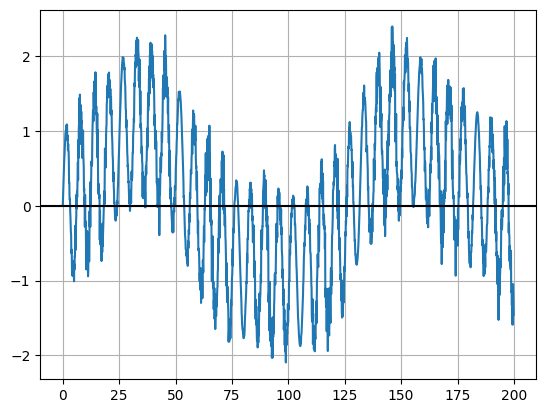

In [78]:
# construct a littel toy dataset
time        = np.arange(0, 200, 0.1)    
amplitude   = np.sin(time) + np.sin(time * 0.05) + \
                np.sin(time * 0.12) * np.random.normal(-0.2, 0.2, len(time))
print(len(amplitude))
plt.plot(time,amplitude)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')

# Split Test Train

In [79]:
sampels = int(len(time) * train_size) # use a parameter to control training size
train_data = amplitude[:sampels]
test_data = amplitude[sampels:]
print(len(train_data), len(test_data))

1600 400


# Create sequence
len of input_data split -> train|test

minus the window_size 

create and Tensor with the dimensions of (L, 2, input_window)

eg: [1-3100 1-3100..., 1-3100 1-3100...] times 100


In [80]:
def create_inout_sequences(input_data, input_window ,output_window):
    inout_seq = []
    L = len(input_data)
    block_num =  L - block_len + 1

    # total of [N - block_len + 1] blocks
    # where block_len = input_window + output_window

    for i in range( block_num ):
        train_seq = input_data[i : i + input_window]
        train_label = input_data[i + output_window : i + input_window + output_window]
        inout_seq.append((train_seq ,train_label))

    return torch.FloatTensor(np.array(inout_seq)) # creates a tensor [L,2,input_window]

train_sequence = create_inout_sequences( train_data,input_window ,output_window)

test_sequence = create_inout_sequences(test_data,input_window,output_window)
print("Train_Tensor size: ", train_sequence.size())
print("Test_Tensor size: ",test_sequence.size())

Train_Tensor size:  torch.Size([1560, 2, 40])
Test_Tensor size:  torch.Size([360, 2, 40])


# Create Class PositionEncoding
even pos = $sin(x * \frac{1}{\frac{1000^{2*dmodel}}{dmodel}})$

odd pos = $cos(x * \frac{1}{\frac{1000^{2*dmodel}}{dmodel}})$

output a tensor 

In [81]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()     
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # div_term = torch.exp(
        #     torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        # )
        div_term = 1 / (10000 ** ((2 * np.arange(d_model)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term[0::2])
        pe[:, 1::2] = torch.cos(position * div_term[1::2])

        pe = pe.unsqueeze(0).transpose(0, 1) # [5000, 1, d_model],so need seq-len <= 5000
        #pe.requires_grad = False
        self.register_buffer('pe', pe)
        print("PositionalEncoding outputSize: ",pe.size())

    def forward(self, x):
        # print(self.pe[:x.size(0), :].repeat(1,x.shape[1],1).shape ,'---',x.shape)
        # dimension 1 maybe inequal batchsize
        return x + self.pe[:x.size(0), :].repeat(1,x.shape[1],1)
    
pos_encoder = PositionalEncoding(modelDim)

PositionalEncoding outputSize:  torch.Size([5000, 1, 400])


In [98]:
import torch.nn.functional as F
import math

class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
    
        self.size = d_model
        
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        
        self.eps = eps
    
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

def attention(q, k, v, d_k, mask=None, dropout=None):
    
    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    
    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)
    
    scores = F.softmax(scores, dim=-1)
    
    if dropout is not None:
        scores = dropout(scores)
        
    output = torch.matmul(scores, v)
    return output

class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.1):
        super().__init__()
        
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        
        bs = q.size(0)
        
        # perform linear operation and split into N heads
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        
        # transpose to get dimensions bs * N * sl * d_model
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)
        

        # calculate attention using function we will define next
        scores = attention(q, k, v, self.d_k, mask, self.dropout)
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous()\
        .view(bs, -1, self.d_model)
        output = self.out(concat)
    
        return output

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        super().__init__() 
    
        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
    
    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x
    
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x
    
# build a decoder layer with two multi-head attention layers and
# one feed-forward layer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)
        
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)
        
        self.attn_1 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.attn_2 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)

    def forward(self, x, e_outputs, src_mask, trg_mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.attn_2(x2, e_outputs, e_outputs, \
        src_mask))
        x2 = self.norm_3(x)
        x = x + self.dropout_3(self.ff(x2))
        return x
    
    import copy

def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(EncoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)
    def forward(self, src, mask):
        x = self.embed(src)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, mask)
        return self.norm(x)
    
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(DecoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)
    def forward(self, trg, e_outputs, src_mask, trg_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x)

class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads, dropout):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads, dropout)
        self.decoder = Decoder(trg_vocab, d_model, N, heads, dropout)
        self.out = nn.Linear(d_model, trg_vocab)
    def forward(self, src, trg, src_mask, trg_mask):
        e_outputs = self.encoder(src, src_mask)
        #print("DECODER")
        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output

def get_model(src_vocab, trg_vocab):

    model = Transformer(len(src_vocab), len(trg_vocab), d_model = 250, N = 1, heads = 1, dropout = 0.1)
       
#    if opt.load_weights is not None:
#        print("loading pretrained weights...")
#        model.load_state_dict(torch.load(f'{opt.load_weights}/model_weights'))
#    else:
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p) 
    
#    if opt.device == 0:
# model = model.cuda()
    
    return 

from torch.autograd import Variable

class Embedder(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embed = nn.Embedding(vocab_size, d_model)
    def forward(self, x):
        return self.embed(x)

class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 200, dropout = 0.1):
        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)
        # create constant 'pe' matrix with values dependant on 
        # pos and i
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = \
                math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = \
                math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
 
    
    def forward(self, x):
        # make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        #add constant to embedding
        seq_len = x.size(1)
        pe = Variable(self.pe[:,:seq_len], requires_grad=False)
        if x.is_cuda:
            pe.cuda()
        x = x + pe
        return self.dropout(x)

model = Transformer(len(train_sequence), len(test_sequence),250,1,1,0.1)
model.train()

def get_batch(input_data, i , batch_size):

    # batch_len = min(batch_size, len(input_data) - 1 - i) #  # Now len-1 is not necessary
    batch_len = min(batch_size, len(input_data) - i)
    data = input_data[ i:i + batch_len ]
    input = torch.stack([item[0] for item in data]).view((input_window,batch_len,1))
    # ( seq_len, batch, 1 ) , 1 is feature size
    target = torch.stack([item[1] for item in data]).view((input_window,batch_len,1))
    return input, target

data, targets = get_batch(train_sequence, 0 , batch_size)
output = model(data)


TypeError: forward() missing 3 required positional arguments: 'trg', 'src_mask', and 'trg_mask'

In [83]:
#max_len = 5
#d_model = 2
#pe = torch.zeros(max_len, d_model)
#print(pe)
#position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#print(position)
#div_term = 1 / (10000 ** ((2 * np.arange(d_model)) / d_model))
#print(div_term)
#pe[:, 0::2] = torch.sin(position * div_term[0::2])
#pe[:, 1::2] = torch.cos(position * div_term[1::2])
#print(pe)
#pe = pe.unsqueeze(0).transpose(0, 1)
#print(pe)
#print(pe.size())

# Create TransformerClass from Pytorch

In [84]:
class TransAm(nn.Module):
    def __init__(self,feature_size=250,num_layers=1,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        self.input_embedding  = nn.Linear(1,feature_size)
        self.src_mask = None

        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        # src with shape (input_window, batch_len, 1)
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            mask = self._generate_square_subsequent_mask(len(src))
            self.src_mask = mask

        src = self.input_embedding(src) # linear transformation before positional embedding
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [96]:
def get_batch(input_data, i , batch_size):

    # batch_len = min(batch_size, len(input_data) - 1 - i) #  # Now len-1 is not necessary
    batch_len = min(batch_size, len(input_data) - i)
    data = input_data[ i:i + batch_len ]
    input = torch.stack([item[0] for item in data]).view((input_window,batch_len,1))
    # ( seq_len, batch, 1 ) , 1 is feature size
    target = torch.stack([item[1] for item in data]).view((input_window,batch_len,1))
    return input, target

In [86]:
def train(train_data,model,optimizer, criterion,epoch,scheduler):
    model.train() # Turn on the train mode \o/
    total_loss = 0.
    #start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data), batch_size)):  # Now len-1 is not necessary
        # data and target are the same shape with (input_window,batch_len,1)
        data, targets = get_batch(train_data, i , batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            #elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                   'ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            #start_time = time.time()
    return model

In [87]:
# predict the next n steps based on the input data 
def predict_future(eval_model, data_source,steps):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    data, _ = get_batch(data_source , 0 , 1)
    with torch.no_grad():
        for i in range(0, steps):            
            output = eval_model(data[-input_window:])
            # (seq-len , batch-size , features-num)
            # input : [ m,m+1,...,m+n ] -> [m+1,...,m+n+1]
            data = torch.cat((data, output[-1:])) # [m,m+1,..., m+n+1]


    print("R2: ",r2_score)
    data = data.cpu().view(-1)

In [88]:
def plot_and_loss(eval_model, data_source,epoch,criterion):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    with torch.no_grad():
        # for i in range(0, len(data_source) - 1):
        for i in range(len(data_source)):  # Now len-1 is not necessary
            data, target = get_batch(data_source, i , 1) # one-step forecast
            output = eval_model(data)            
            total_loss += criterion(output, target).item()
            test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0)
            truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)
            
    #test_result = test_result.cpu().numpy() -> no need to detach stuff.. 
    len(test_result)
    print("R2 Score: ", r2_score(test_result,truth))

    return test_result, truth

In [89]:
model = TransAm(feature_size = modelDim)
criterion = nn.MSELoss()
lr = 0.005 
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)

best_val_loss = float("inf")
epochs = 10 # The number of epochs
best_model = None

PositionalEncoding outputSize:  torch.Size([5000, 1, 400])


In [91]:
for epoch in range(1, epochs + 1):
    model = train(train_sequence,model,optimizer, criterion,epoch,scheduler)
    #predict_future(model, test_sequence,200)
    test_result, truth = plot_and_loss(model, test_sequence,epoch,criterion)

    scheduler.step() 
plt.plot(test_result,color="red")
plt.plot(truth,color="blue")
plt.grid()

C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   1 |    31/  156 batches | lr 0.005000 | 27.73 ms | ppl 1100007125220.00
| epoch   1 |    62/  156 batches | lr 0.005000 |  0.59 ms | ppl     1.80
| epoch   1 |    93/  156 batches | lr 0.005000 |  0.55 ms | ppl     1.73
| epoch   1 |   124/  156 batches | lr 0.005000 |  0.26 ms | ppl     1.29
| epoch   1 |   155/  156 batches | lr 0.005000 |  0.25 ms | ppl     1.29
R2 Score:  -0.5429542418618496


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   2 |    31/  156 batches | lr 0.004513 |  0.24 ms | ppl     1.27
| epoch   2 |    62/  156 batches | lr 0.004513 |  0.15 ms | ppl     1.16


KeyboardInterrupt: 